In [135]:
# Imports

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import statsmodels.api as sm
import itertools

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)
warnings.filterwarnings("ignore")

In [149]:
# date range
start_date = '1/1/2016'
end_date = '31/12/2018'
date_rng = pd.date_range(start=start_date, end=end_date, freq='D')

df = pd.DataFrame(date_rng, columns=['date'])
# df['data'] = np.random
print("There are %d entries"%(len(df)))
display(df.head())

There are 1096 entries


,date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [150]:
# generating data for server response times over the years

# assuming servers get x% faster every year
annual_trend = -20

# months where traffic increases
seasonal_months = [11, 12, 1]
# y% delay caused by increase in traffic
seasonal_delay = 20

# add z% of randomly generated noise
residual = 10

# using chi-squared distribution

# size of dataframe
num = len(df)
k = 1

data = np.random.chisquare(1, num)

# adding noise to data
for i in range(1, len(data)):
    r = np.random.rand()
    data[i] += r

df['data'] = data

# adding trend to data
years = df['date'].dt.year.unique()
cumulative_trend = 0
yearly_mean = df[df['date'].dt.year == years[0]]['data'].mean()
for i in range(1, len(years)):
    c_year = years[i]
    trend = yearly_mean*annual_trend/100
    cumulative_trend += trend
#     print(trend, yearly_mean, c_year)
    df['data'] = df.apply(lambda r: (r['data'] + cumulative_trend) if (r['date'].year == c_year) else r['data'], axis=1)
    
    yearly_mean = df[df['date'].dt.year == c_year]['data'].mean()

# adding seasonal component to data
df['data'] = df.apply(lambda r: (r['data'] + seasonal_delay/100) if (r['date'].month in seasonal_months) else r['data'], axis=1)

df['data'] = df.apply(lambda r: (np.random.rand()) if r['data'] <= 0 else r['data'], axis=1)

df = df.set_index('date')

display(df.head())
display(df.tail())
df['data'].describe()

,data
date,
2016-01-01,0.282538
2016-01-02,0.487822
2016-01-03,1.867337
2016-01-04,0.920262
2016-01-05,0.335523


,data
date,
2018-12-27,2.454974
2018-12-28,2.437267
2018-12-29,2.685999
2018-12-30,0.340404
2018-12-31,1.939078


count    1096.000000
mean        1.317787
std         1.449296
min         0.002610
25%         0.439533
50%         0.845501
75%         1.670442
max        20.081269
Name: data, dtype: float64

Text(0.5, 1.0, 'Response Time over time')

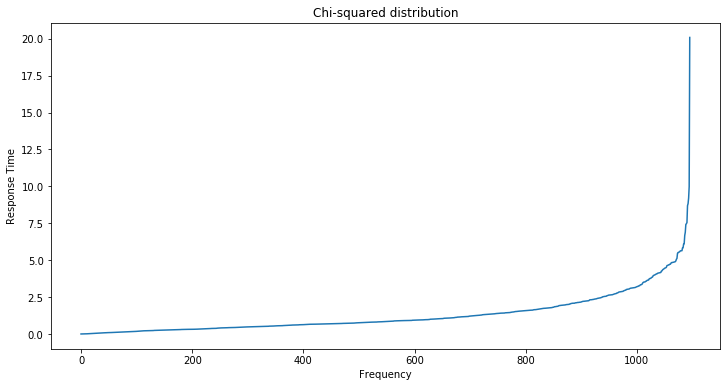

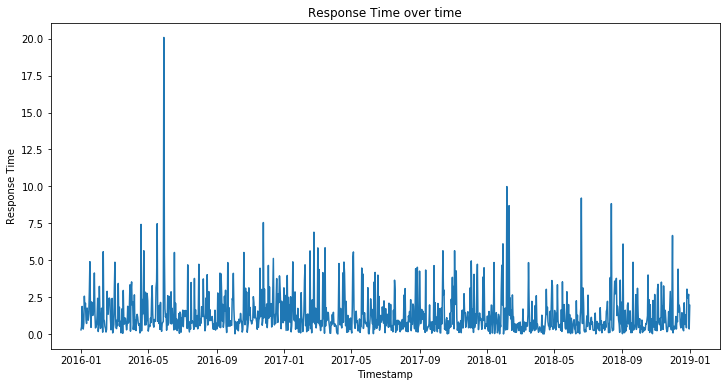

In [151]:
plt.figure()
plt.plot(range(len(df)), np.sort(df['data']))
plt.xlabel("Frequency")
plt.ylabel("Response Time")
plt.title("Chi-squared distribution")

plt.figure()
plt.plot(df.index, df['data'])
plt.xlabel("Timestamp")
plt.ylabel("Response Time")
plt.title("Response Time over time")

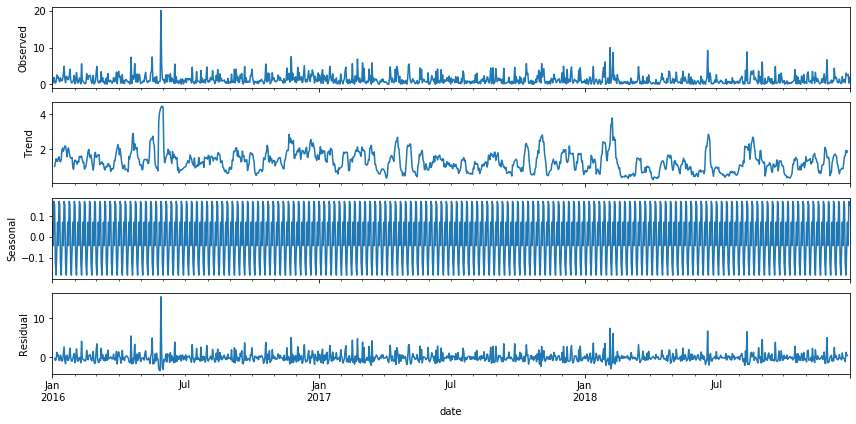

In [152]:
# decomposing the time series

decomposition = sm.tsa.seasonal_decompose(df['data'], model='additive')
fig = decomposition.plot()
plt.show()

In [153]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 365)
SARIMAX: (0, 0, 1) x (0, 1, 0, 365)
SARIMAX: (0, 1, 0) x (0, 1, 1, 365)
SARIMAX: (0, 1, 0) x (1, 0, 0, 365)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df['data'],
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 365)12 - AIC:4582.349218097676
